In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

In [3]:
DB_PATH = r'E:\AIML Tasks\database.sqlite' 
OUTPUT_IMAGE = 'svm_soccer_boundary.png'

In [4]:
def load_data(db_path):
    """
    We use Betting Odds (B365H, B365A) as features to predict the Match Outcome.
    """
    print("Connecting to database...")
    try:
        conn = sqlite3.connect(db_path)
    except Exception as e:
        print(f"Error: Could not connect to database. Ensure '{db_path}' is in the directory.")
        return None, None

    # Query: Get goals and betting odds (Bet365)
    # Filter out matches where betting odds are missing
    query = """
    SELECT 
        home_team_goal, 
        away_team_goal, 
        B365H, 
        B365A 
    FROM Match 
    WHERE B365H IS NOT NULL 
      AND B365A IS NOT NULL
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    print(f"Data loaded. Rows: {len(df)}")
    
    # Feature Engineering
    # Target: 1 if Home Team Won, 0 otherwise (Draw or Away Win)
    df['target'] = np.where(df['home_team_goal'] > df['away_team_goal'], 1, 0)
    
    # Features: Home Odds and Away Odds
    X = df[['B365H', 'B365A']]
    y = df['target']
    
    return X, y

In [6]:
def train_and_visualize(X, y):
    """
    Trains SVM models, tunes hyperparameters, and visualizes the decision boundary.
    """
    # 1. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 2. Scale Data (Crucial for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 3. Hyperparameter Tuning 
    print("\nTuning Hyperparameters (this may take a moment)...")
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf']
    }
    
    # Using a smaller subset for GridSearch speed if dataset is huge, 
    # but here we use full training set for accuracy.
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=3)
    grid.fit(X_train_scaled, y_train)
    
    print(f"Best Parameters: {grid.best_params_}")
    best_model = grid.best_estimator_
    
    # 4. Evaluation
    y_pred = best_model.predict(X_test_scaled)
    print("\n--- Model Performance ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=['Not Home Win', 'Home Win']))
    
    # 5. Visualization (2D Decision Boundary)
    # Since we only have 2 features (B365H, B365A), we don't need PCA.
    # We can plot directly.
    
    print("Generating Visualization...")
    X_vis = X_test_scaled[:, :2]  # Use first 2 columns (which is all we have)
    
    # Create meshgrid
    h = .02
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict on meshgrid
    Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', s=20)
    
    plt.title(f"SVM Decision Boundary: Predicting Home Wins\n(Based on Betting Odds)")
    plt.xlabel('Scaled Home Odds (B365H)')
    plt.ylabel('Scaled Away Odds (B365A)')
    plt.legend(*scatter.legend_elements(), title="Outcome")
    plt.savefig(OUTPUT_IMAGE)
    print(f"Visualization saved to {OUTPUT_IMAGE}")
    plt.show()

Connecting to database...
Data loaded. Rows: 22592

Tuning Hyperparameters (this may take a moment)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

--- Model Performance ---
Accuracy: 0.6442
              precision    recall  f1-score   support

Not Home Win       0.63      0.79      0.70      2393
    Home Win       0.67      0.48      0.56      2126

    accuracy                           0.64      4519
   macro avg       0.65      0.63      0.63      4519
weighted avg       0.65      0.64      0.63      4519

Generating Visualization...
Visualization saved to svm_soccer_boundary.png


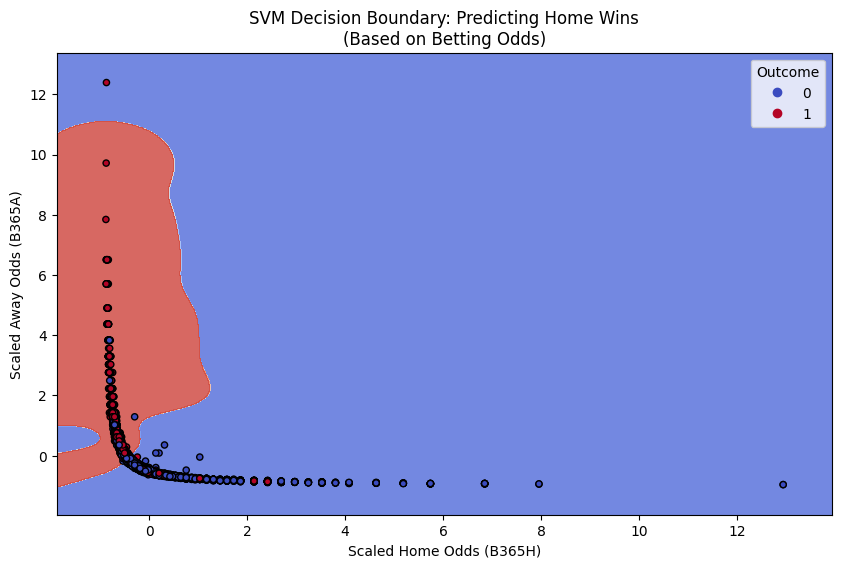

In [7]:
if __name__ == "__main__":
    X, y = load_data(DB_PATH)
    if X is not None:
        train_and_visualize(X, y)